In [215]:
# Global imports and settings
from preamble import *
%matplotlib inline
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
interactive = False # Set to True for interactive plots 
if interactive:
    plt.rcParams['figure.dpi'] = 150
    table_font_size = '30px'
else:
    plt.rcParams['figure.dpi'] = 100
    table_font_size = '20px'

In [216]:
# Additional libraries. Uncomment to install them if you don't have them
# For feature selection
# !pip install mlxtend

# For feature encoding
# !pip install category_encoders

# For feature imputation (requires TensorFlow)
# !pip install --user fancyimpute

# For data imbalance selection
# !pip install imblearn

## Lecture 6. Data preprocessing

**Real-world machine learning pipelines**

Joaquin Vanschoren

## Data transformations

* Machine learning models make a lot of assumptions about the data
* In reality, these assumptions are often violated
* We build _pipelines_ that _transform_ the data before feeding it to the learners
    * Scaling (or other numeric transformations)
    * Encoding (convert categorical features into numerical ones)
    * Automatic feature selection
    * Feature engineering (e.g. binning, polynomial features,...)
    * Handling missing data
    * Handling imbalanced data
    * Dimensionality reduction (e.g. PCA)
    * Learned embeddings (e.g. for text)
* Seek the best combinations of transformations and learning methods
    * Often done empirically, using cross-validation
    * Make sure that there is no data leakage during this process!

## Scaling
* Use when different numeric features have different scales (different range of values)
    * Features with much higher values may overpower the others
* Goal: bring them all within the same range
* Different methods exist

In [217]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Iris dataset with some added noise
def noisy_iris():
    iris = fetch_openml("iris", return_X_y=True)
    X, y = iris
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, 150)
    for i in range(4):
        X[:, i] = X[:, i] + noise
    X[:, 0] = X[:, 0]+3 # add more skew 
    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)
    return X, y

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer(norm='l1'), MaxAbsScaler()]

@interact
def plot_scaling(scaler=scalers):
    X, y = noisy_iris()
    X = X[:,:2] # Use only first 2 features
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    axes[0].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="brg")
    maxx = np.abs(X[:, 0]).max()
    maxy = np.abs(X[:, 1]).max()
    axes[0].set_xlim(-maxx + 1, maxx + 1)
    axes[0].set_ylim(-maxy + 1, maxy + 1)
    axes[0].set_title("Original Data")
    
    X_ = scaler.fit_transform(X)
    axes[1].scatter(X_[:, 0], X_[:, 1], c=y, s=10, cmap="brg")
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    axes[1].set_title(type(scaler).__name__)
    axes[1].set_xticks([-1,1])
    axes[1].set_yticks([-1,1])

    for ax in axes:
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('center')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

interactive(children=(Dropdown(description='scaler', options=(StandardScaler(), RobustScaler(), MinMaxScaler()…

In [218]:
if not interactive:
    plot_scaling(scalers[0])

### Why do we need scaling?
* KNN: Distances depend mainly on feature with larger values
* SVMs: (kernelized) dot products are also based on distances
* Linear model: Feature scale affects regularization
    * Weights have similar scales, more interpretable

In [219]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Example by Andreas Mueller, with some tweaks
def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1):
    # multiclass                                                                  
    if eps is None:                                                               
        eps = X.std(axis=0) / 2.
    else:
        eps = np.array([eps, eps])

    if ax is None:                                                                
        ax = plt.gca()                                                            

    x_min, x_max = X[:, 0].min() - eps[0], X[:, 0].max() + eps[0]
    y_min, y_max = X[:, 1].min() - eps[1], X[:, 1].max() + eps[1]
    # these should be 1000 but knn predict is unnecessarily slow
    xx = np.linspace(x_min, x_max, 100)                                          
    yy = np.linspace(y_min, y_max, 100)                                          

    X1, X2 = np.meshgrid(xx, yy)                                                  
    X_grid = np.c_[X1.ravel(), X2.ravel()]                                        
    decision_values = classifier.predict(X_grid)                                  
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,            
                                                       y_min, y_max),             
            aspect='auto', origin='lower', alpha=alpha, cmap=plt.cm.bwr)     

clfs = [KNeighborsClassifier(), SVC(), LinearSVC(), LogisticRegression(C=10)]

@interact
def plot_scaling_effect(classifier=clfs, show_test=[False,True]):
    X, y = make_blobs(centers=2, random_state=4, n_samples=50)
    X = X * np.array([1000, 1])
    y[7], y[27] = 0, 0 
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    
    clf2 = clone(classifier)
    clf_unscaled = classifier.fit(X_train, y_train)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[0].set_title("Without scaling. Accuracy:{:.2f}".format(clf_unscaled.score(X_test,y_test)))
    if show_test: # Hide test data for simplicity
        axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', cmap='bwr', label="test") 
        axes[0].legend()
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf_scaled = clf2.fit(X_train_scaled, y_train)

    axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='bwr', label="train")
    axes[1].set_title("With scaling. Accuracy:{:.2f}".format(clf_scaled.score(X_test_scaled,y_test)))   
    if show_test: # Hide test data for simplicity
        axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker='^', cmap='bwr', label="test")
        axes[1].legend()

    plot_2d_classification(clf_unscaled, X, ax=axes[0], alpha=.2)
    plot_2d_classification(clf_scaled, scaler.transform(X), ax=axes[1], alpha=.3)

interactive(children=(Dropdown(description='classifier', options=(KNeighborsClassifier(), SVC(), LinearSVC(), …

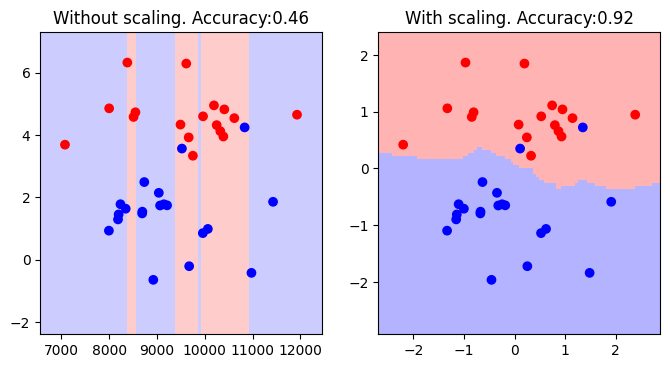

In [220]:
if not interactive:
    plot_scaling_effect(classifier=clfs[0], show_test=False)

### Standard scaling (standardization)
* Generally most useful, assumes data is more or less normally distributed
* Per feature, subtract the mean value $\mu$, scale by standard deviation $\sigma$
* New feature has $\mu=0$ and $\sigma=1$, values can still be arbitrarily large
$$\mathbf{x}_{new} = \frac{\mathbf{x} - \mu}{\sigma}$$

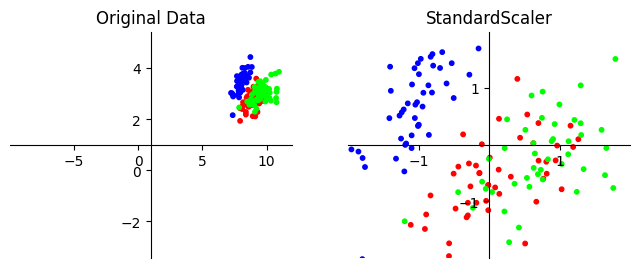

In [221]:
plot_scaling(scaler=StandardScaler())

### Min-max scaling
* Scales all features between a given $min$ and $max$ value (e.g. 0 and 1)
* Makes sense if min/max values have meaning in your data
* Sensitive to outliers

$$\mathbf{x}_{new} = \frac{\mathbf{x} - x_{min}}{x_{max} - x_{min}} \cdot (max - min) + min $$

In [222]:
plot_scaling(scaler=MinMaxScaler(feature_range=(0, 1)))

### Robust scaling
* Subtracts the median, scales between quantiles $q_{25}$ and $q_{75}$
* New feature has median 0, $q_{25}=-1$ and $q_{75}=1$
* Similar to standard scaler, but ignores outliers

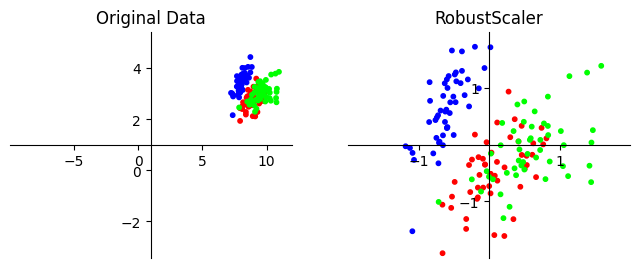

In [223]:
plot_scaling(scaler=RobustScaler())

### Normalization
* Makes sure that feature values of each point (each row) sum up to 1 (L1 norm)
    * Useful for count data (e.g. word counts in documents)
* Can also be used with L2 norm (sum of squares is 1)
    * Useful when computing distances in high dimensions
    * Normalized Euclidean distance is equivalent to cosine similarity 

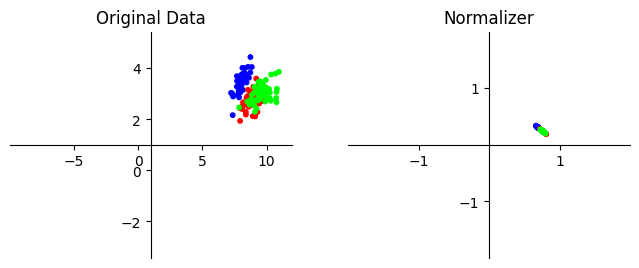

In [224]:
plot_scaling(scaler=Normalizer(norm='l1'))

### Maximum Absolute scaler
* For sparse data (many features, but few are non-zero)
    * Maintain sparseness (efficient storage)
* Scales all values so that maximum absolute value is 1
* Similar to Min-Max scaling without changing 0 values

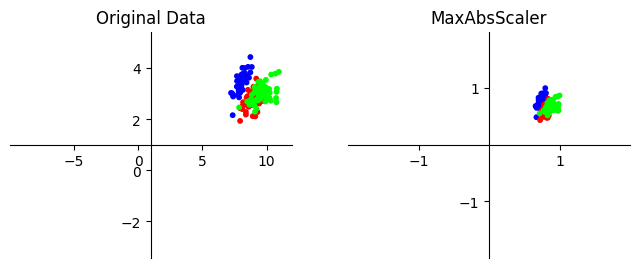

In [225]:
plot_scaling(scaler=MaxAbsScaler())

### Power transformations
* Some features follow certain distributions
    * E.g. number of twitter followers is log-normal distributed
* Box-Cox transformations transform these to normal distributions ($\lambda$ is fitted)
    * Only works for positive values, use Yeo-Johnson otherwise
$$bc_{\lambda}(x) = \begin{cases} log(x) & \lambda = 0\\ \frac{x^{\lambda}-1}{\lambda} & \lambda \neq 0 \\ \end{cases}$$

In [226]:
# Adapted from an example by Eric Chang and Nicolas Hug 
from sklearn.preprocessing import PowerTransformer

# Power transformer with Box-Cox
bc = PowerTransformer(method='box-cox')

# Generate data
rng = np.random.RandomState(304) # Random number generator
size = (1000, 1)
X_lognormal = rng.lognormal(size=size) # lognormal distribution
X_chisq = rng.chisquare(df=3, size=size) # chi-squared distribution
X_weibull = rng.weibull(a=50, size=size) # weibull distribution

# create plots
distributions = [
    ('Lognormal', X_lognormal),
    ('Chi-squared', X_chisq),
    ('Weibull', X_weibull)
]
colors = ['#D81B60', '#0188FF', '#FFC107']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 3))
axes = axes.flatten()
axes_idxs = [(0, 3), (1, 4), (2, 5)]
axes_list = [(axes[i], axes[j]) for (i, j) in axes_idxs]

for distribution, color, axes in zip(distributions, colors, axes_list):
    name, X = distribution
    X_train, X_test = train_test_split(X, test_size=.5)

    # perform power transforms and quantile transform
    X_trans_bc = bc.fit(X_train).transform(X_test)
    lmbda_bc = round(bc.lambdas_[0], 2)

    ax_original, ax_bc = axes
    ax_original.hist(X_train, color=color, bins=30)
    ax_original.set_title(name)
    ax_original.tick_params(axis='both', which='major')

    ax_bc.hist(X_trans_bc, color=color, bins=30)
    title = 'After {}'.format('Box-Cox')
    if lmbda_bc is not None:
        title += r' $\lambda$ = {}'.format(lmbda_bc)
    ax_bc.set_title(title)
    ax_bc.tick_params(axis='both', which='major')
    ax_bc.set_xlim([-3.5, 3.5])


plt.tight_layout()
plt.show()

In [227]:
heading_properties = [('font-size', table_font_size)]
cell_properties = [('font-size', table_font_size)]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

## Categorical feature encoding
* Many algorithms can only handle numeric features, so we need to encode the categorical ones

In [228]:
import pandas as pd
X = pd.DataFrame({'boro': ['Manhattan', 'Queens', 'Manhattan', 'Brooklyn', 'Brooklyn', 'Bronx'],
                   'salary': [103, 89, 142, 54, 63, 219]})
y = pd.DataFrame({'vegan': [0, 0, 0, 1, 1, 0]})
df = X.copy()
df['vegan'] = y
df.style.set_table_styles(dfstyle)

### Ordinal encoding
* Simply assigns an integer value to each category in the order they are encountered
* Only really useful if there exist a natural order in categories
    * Model will consider one category to be 'higher' or 'closer' to another

In [229]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype=int)

# Encode first feature, rest passthrough
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0])], remainder='passthrough')
X_ordinal = preprocessor.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=X_ordinal, columns=["boro_ordinal","salary"])
df = pd.concat([X['boro'], df], axis=1)
df.style.set_table_styles(dfstyle)

### One-hot encoding (dummy encoding)
* Simply adds a new 0/1 feature for every category, having 1 (hot) if the sample has that category
* Can explode if a feature has lots of values, causing issues with high dimensionality
* What if test set contains a new category not seen in training data?
    * Either ignore it (just use all 0's in row), or handle manually (e.g. resample) 

In [230]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(dtype=int)

# Encode first feature, rest passthrough
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0])], remainder='passthrough')
X_ordinal = preprocessor.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=X_ordinal, columns=["boro_Bronx","boro_Brooklyn","boro_Manhattan","boro_Queens","salary"])
df = pd.concat([X['boro'], df], axis=1)
df.style.set_table_styles(dfstyle)

### Target encoding
* Value close to 1 if category correlates with class 1, close to 0 if correlates with class 0
* Preferred when you have lots of category values. It only creates one new feature per class
* Blends posterior probability of the target $\frac{n_{iY}}{n_i}$ and prior probability $\frac{n_Y}{n}$.
    * $n_{iY}$: nr of samples with category i and class Y=1, $n_{i}$: nr of samples with category i
    * Blending: gradually decrease as you get more examples of category i and class Y=0
$$Enc(i) = \color{blue}{\frac{1}{1+e^{-(n_{i}-1)}} \frac{n_{iY}}{n_i}} + \color{green}{(1-\frac{1}{1+e^{-(n_{i}-1)}}) \frac{n_Y}{n}}$$
    * Same for regression, using $\frac{n_{iY}}{n_i}$: average target value with category i, $\frac{n_{Y}}{n}$: overall mean


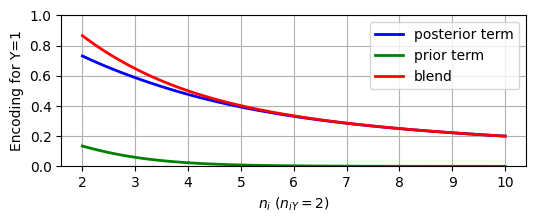

In [231]:
# smoothed sigmoid
def sigmoid(x, smoothing=1):
    return 1 / (1 + np.exp(-(x-1)/smoothing))

def plot_blend():
    n = 20 # 20 points
    ny = 10 # 10 points of class Yes
    niy = 2 # number of points of category i and class Yes
    ni = np.linspace(niy,10,100) #  10 points of category i
    
    fig, ax = plt.subplots(figsize=(6,2))

    ax.plot(ni,sigmoid(ni)*(niy/ni),lw=2,c='b',label='posterior term', linestyle='-')
    ax.plot(ni,(1-sigmoid(ni))*(ny/n),lw=2,c='g',label='prior term', linestyle='-')
    ax.plot(ni,sigmoid(ni)*(niy/ni) + (1-sigmoid(ni))*(ny/n),lw=2,c='r',label='blend', linestyle='-')
    ax.set_xlabel(r"$n_{i}$ ($n_{iY} = 2$)")
    ax.set_ylabel("Encoding for Y=1")
    ax.set_ylim(0,1)
    plt.grid()
    plt.legend();
plot_blend()

#### Example:
* For Brooklyn, $n_{iY}=2, n_{i}=2, n_{Y}=2, n=6$ 
* Would be closer to 1 if there were more examples, all with label 1
$$Enc(Brooklyn) = \frac{1}{1+e^{-1}} \frac{2}{2} + (1-\frac{1}{1+e^{-1}}) \frac{2}{6}  = 0,82$$
* Note: the implementation used here sets $Enc(i)=\frac{n_Y}{n}$ when $n_{iY}=1$


In [232]:
# Not in sklearn yet, use package category_encoders
from category_encoders import TargetEncoder

encoder = TargetEncoder(return_df=True)
encoder.fit(X, y)
pd_te = encoder.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=pd_te, columns=["boro","salary"]).rename(columns={'boro': 'boro_encoded'})
df = pd.concat([X['boro'], df, y], axis=1)
df.style.set_table_styles(dfstyle)

### In practice (scikit-learn)

* Ordinal encoding and one-hot encoding are implemented in scikit-learn
    * dtype defines that the output should be an integer

```python
ordinal_encoder = OrdinalEncoder(dtype=int)
one_hot_encoder = OneHotEncoder(dtype=int)
```

* Target encoding is available in `category_encoders`
    * scikit-learn compatible
    * Also includes other, very specific encoders
 
```python
target_encoder = TargetEncoder(return_df=True)
```

* All encoders (and scalers) follow the `fit-transform` paradigm
    * `fit` prepares the encoder, `transform` actually encodes the features
    * We'll discuss this next

```python
encoder.fit(X, y)
X_encoded = encoder.transform(X,y)
```

## Applying data transformations
* Data transformations should always follow a fit-predict paradigm
    * Fit the transformer on the training data only
        * E.g. for a standard scaler: record the mean and standard deviation
    * Transform (e.g. scale) the training data, then train the learning model
    * Transform (e.g. scale) the test data, then evaluate the model
* Only scale the input features (X), not the targets (y)
* If you fit and transform the whole dataset before splitting, you get data leakage
    * You have looked at the test data before training the model
    * Model evaluations will be misleading
* If you fit and transform the training and test data separately, you distort the data
    * E.g. training and test points are scaled differently

### In practice (scikit-learn)

``` python
# choose scaling method and fit on training data
scaler = StandardScaler()
scaler.fit(X_train)

# transform training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

``` python
# calling fit and transform in sequence
X_train_scaled = scaler.fit(X_train).transform(X_train)
# same result, but more efficient computation
X_train_scaled = scaler.fit_transform(X_train)
```

### Test set distortion example
* Properly scaled: `fit` on training set, `transform` on training and test set
* Improperly scaled: `fit` and `transform` on the training and test data separately
    * Test data points nowhere near same training data points

In [233]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from sklearn.datasets import make_blobs
# make synthetic data
X, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
# split it into training and test set
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

# plot the training and test set
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].scatter(X_train[:, 0], X_train[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# visualize the properly scaled data
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[1].set_title("Scaled Data")

# rescale the test set separately
# so that test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],
                marker='^', c=mglearn.cm2(1), label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

### Data leakage example
* Cross-validation: training set is split into training and validation sets for model selection
* Incorrect: Scaler is fit on whole training set before doing cross-validation
    * Data leaks from validation folds into training folds, selected model may be optimistic
* Right: Scaler is fit on training folds only

<img src="../images/infoleak.png" alt="ml" style="width: 1500px;"/>

## Pipelines
* A pipeline is a combination of data transformation and learning algorithms
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
    * Ensures that data transformations are applied correctly
    
<img src="../images/07_pipelines.png" alt="ml" style="width: 600px;"/>

### In practice (scikit-learn)
* A `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be data transformer (have a `transform` method)

``` python
# Make pipeline, step names will be 'minmaxscaler' and 'linearsvc'
pipe = make_pipeline(MinMaxScaler(), LinearSVC())
# Build pipeline with named steps 
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

# Correct fit and score
score = pipe.fit(X_train, y_train).score(X_test, y_test)
# Retrieve trained model by name
svm = pipe.named_steps["svm"]
```

``` python
# Correct cross-validation
scores = cross_val_score(pipe, X, y)
```

### In practice (scikit-learn), continued
* If you want to apply different preprocessors to different columns, use `ColumnTransformer`
* If you want to merge pipelines, you can use `FeatureUnion` to concatenate columns

``` python
# 2 sub-pipelines, one for numeric features, other for categorical ones
numeric_pipe = make_pipeline(SimpleImputer(),StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(),OneHotEncoder())

# Using categorical pipe for features A,B,C, numeric pipe otherwise
preprocessor = make_column_transformer((categorical_pipe,["A","B","C"]), 
                                       remainder=numeric_pipe)

# Combine with learning algorithm in another pipeline
pipe = make_pipeline(preprocess, LinearSVC())
```

``` python
# Feature union of PCA features and selected features
union = FeatureUnion([("pca", PCA()), ("selected", SelectKBest())])
pipe = make_pipeline(union, LinearSVC())
```

### In practice (scikit-learn), continued
* `ColumnTransformer` concatenates features in order

``` python
pipe = make_column_transformer((StandardScaler(),numeric_features), 
                               (PCA(),numeric_features),  
                               (OneHotEncoder(),categorical_features))
```

<img src="../images/columntransformer.png" alt="ml" style="width: 900px;"/>

### Model selection (scikit-learn)
* We can safely use pipelines in model selection (e.g. grid search)
* Use `'__'` to refer to the hyperparameters of a step, e.g. `svm__C`

``` python
# Correct grid search (can have hyperparameters of any step)
param_grid = {'svm__C': [0.001, 0.01],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X,y)
# Best estimator is now the best pipeline
best_pipe = grid.best_estimator_

# Tune pipeline and evaluate on held-out test set
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X_train,y_train)
grid.score(X_test,y_test)

```

#### Example: Tune multiple steps at once
``` python
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(), Ridge())
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X_train, y_train)
```

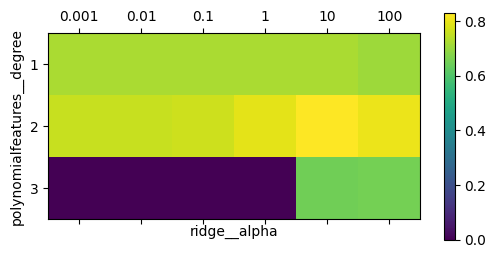

In [234]:
from sklearn.datasets import load_boston
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train);

#plot
fig, ax = plt.subplots(figsize=(6, 3))
im = ax.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
ax.set_xlabel("ridge__alpha")
ax.set_ylabel("polynomialfeatures__degree")
ax.set_xticks(range(len(param_grid['ridge__alpha'])))
ax.set_xticklabels(param_grid['ridge__alpha'])
ax.set_yticks(range(len(param_grid['polynomialfeatures__degree'])))
ax.set_yticklabels(param_grid['polynomialfeatures__degree'])
plt.colorbar(im);

## Automatic Feature Selection

It can be a good idea to reduce the number of features to only the most useful ones
- Simpler models that generalize better (less overfitting)
    - Curse of dimensionality (e.g. kNN)
    - Even models such as RandomForest can benefit from this
    - Sometimes it is one of the main methods to improve models (e.g. gene expression data)
- Faster prediction and training
    - Training time can be quadratic (or cubic) in number of features
- Easier data collection, smaller models (less storage)
- More interpretable models: fewer features to look at

#### Example: bike sharing
* The Bike Sharing Demand dataset shows the amount of bikes rented in Washington DC
* Some features are clearly more informative than others (e.g. temp, hour)
* Some are correlated (e.g. temp and feel_temp)
* We add two random features at the end

In [235]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

# Get bike sharing data from OpenML
bikes = fetch_openml(data_id=42713, as_frame=True)
X_bike_cat, y_bike = bikes.data, bikes.target

# One-hot encode the categorical features
encoder = OneHotEncoder(dtype=int)
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0,7])], remainder='passthrough')
X_bike = preprocessor.fit_transform(X_bike_cat,y)

# Add 2 random features at the end
random_features = np.random.rand(len(X_bike),2)
X_bike = np.append(X_bike,random_features, axis=1)

# Create feature names
bike_names = ['summer','winter', 'spring', 'fall', 'clear', 'misty', 'rain', 'heavy_rain']
bike_names.extend(X_bike_cat.columns[1:7])
bike_names.extend(X_bike_cat.columns[8:])
bike_names.extend(['random_1','random_2'])

In [236]:
#pd.set_option('display.max_columns', 20)
#pd.DataFrame(data=X_bike, columns=bike_names).head()

In [237]:
fig, axes = plt.subplots(2, 10, figsize=(12, 4))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X_bike[:, i], y_bike[:], '.', alpha=.1)
    ax.set_xlabel("{}".format(bike_names[i]))
    ax.get_yaxis().set_visible(False)
for i in range(2):
    axes[i][0].get_yaxis().set_visible(True)
    axes[i][0].set_ylabel("count")
fig.tight_layout()

In [238]:
#fig, ax = plt.subplots(figsize=(6, 2))
#ax.plot(X_bike[:, 2])
#ax.plot(X_bike[:, 14])

### Unsupervised feature selection
* Variance-based
    * Remove (near) constant features
        * Choose a small variance threshold
    * Scale features before computing variance!
    * Infrequent values may still be important
* Covariance-based
    * Remove correlated features
    * The small differences may actually be important
        * You don't know because you don't consider the target

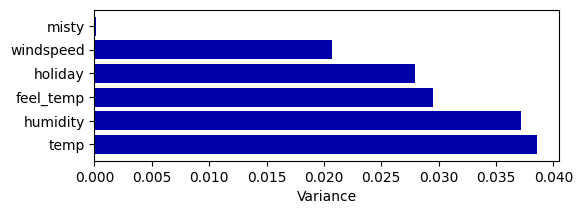

In [239]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold().fit(MinMaxScaler().fit_transform(X_bike))
variances = selector.variances_
var_sort = np.argsort(variances)

plt.figure(figsize=(6, 2))
ypos = np.arange(6)[::-1]
plt.barh(ypos, variances[var_sort][:6], align='center')
plt.yticks(ypos, np.array(bike_names)[var_sort][:6])
plt.xlabel("Variance");

#### Covariance based feature selection
* Remove features $X_i$ (= $\mathbf{X_{:,i}}$) that are highly correlated (have high correlation coefficient $\rho$)
$$\rho (X_1,X_2)={\frac  {{\mathrm  {cov}}(X_1,X_2)}{\sigma (X_1)\sigma (X_2)}} = {\frac { \frac{1}{N-1} \sum_i (X_{i,1} - \overline{X_1})(X_{i,2} - \overline{X_2}) }{\sigma (X_1)\sigma (X_2)}}$$
* Should we remove `feel_temp`? Or `temp`? Maybe one correlates more with the target?

In [240]:
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy

X_bike_scaled = scale(X_bike)
cov = np.cov(X_bike_scaled, rowvar=False)

order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")
bike_names_ordered = [bike_names[i] for i in order]

plt.figure(figsize=(4.2, 4.2))
plt.imshow(cov[order, :][:, order], cmap='bwr')
plt.xticks(range(X_bike.shape[1]), bike_names_ordered, ha="right")
plt.yticks(range(X_bike.shape[1]), bike_names_ordered)
plt.xticks(rotation=45)
plt.colorbar(fraction=0.046, pad=0.04);

In [241]:
from sklearn.feature_selection import f_regression, SelectPercentile, mutual_info_regression, SelectFromModel, RFE
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance

# Pre-compute all importances on bike sharing dataset
# Scaled feature selection thresholds
thresholds = [0.25, 0.5, 0.75, 1]
# Dict to store all data
fs = {}
methods = ['FTest','MutualInformation','RandomForest','Ridge','Lasso','RFE',
           'ForwardSelection','FloatingForwardSelection','Permutation']
for m in methods:
    fs[m] = {}
    fs[m]['select'] = {}
    fs[m]['cv_score'] = {}

def cv_score(selector):
    model = RandomForestRegressor() #RidgeCV() #RandomForestRegressor(n_estimators=100) 
    select_pipe = make_pipeline(StandardScaler(), selector, model)    
    return np.mean(cross_val_score(select_pipe, X_bike, y_bike, cv=3))

# Tuned RF (pre-computed to save time)
# param_grid = {"max_features":[2,4,8,16],"max_depth":[8,16,32,64,128]}
# randomforestCV = GridSearchCV(RandomForestRegressor(n_estimators=200),
#                              param_grid=param_grid).fit(X_bike, y_bike).best_estimator_
randomforestCV = RandomForestRegressor(n_estimators=200,max_features=16,max_depth=128)

# F test
print("Computing F test")
fs['FTest']['label'] = "F test"
fs['FTest']['score'] = f_regression(scale(X_bike),y_bike)[0]
fs['FTest']['scaled_score'] = fs['FTest']['score'] / np.max(fs['FTest']['score'])
for t in thresholds:
    selector = SelectPercentile(score_func=f_regression, percentile=t*100).fit(scale(X_bike), y_bike)
    fs['FTest']['select'][t] = selector.get_support()
    fs['FTest']['cv_score'][t] = cv_score(selector)

# Mutual information
print("Computing Mutual information")
fs['MutualInformation']['label'] = "Mutual Information"
fs['MutualInformation']['score'] = mutual_info_regression(scale(X_bike),y_bike,discrete_features=range(13)) # first 13 features are discrete
fs['MutualInformation']['scaled_score'] = fs['MutualInformation']['score'] / np.max(fs['MutualInformation']['score'])
for t in thresholds:
    selector = SelectPercentile(score_func=mutual_info_regression, percentile=t*100).fit(scale(X_bike), y_bike)
    fs['MutualInformation']['select'][t] = selector.get_support()
    fs['MutualInformation']['cv_score'][t] = cv_score(selector)
    
# Random Forest
print("Computing Random Forest")
fs['RandomForest']['label'] = "Random Forest"
fs['RandomForest']['score'] = randomforestCV.fit(X_bike, y_bike).feature_importances_
fs['RandomForest']['scaled_score'] = fs['RandomForest']['score'] / np.max(fs['RandomForest']['score'])
for t in thresholds:
    selector = SelectFromModel(randomforestCV, threshold="{}*mean".format((1-t))).fit(X_bike, y_bike) # Threshold can't be easily scaled here
    fs['RandomForest']['select'][t] = selector.get_support()
    fs['RandomForest']['cv_score'][t] = cv_score(selector)
    
# Ridge, Lasso
for m in [RidgeCV(),LassoCV()]:
    name = m.__class__.__name__.replace('CV','')
    print("Computing", name)
    fs[name]['label'] = name
    fs[name]['score'] = m.fit(X_bike, y_bike).coef_
    fs[name]['scaled_score'] = np.abs(fs[name]['score']) / np.max(np.abs(fs[name]['score'])) # Use absolute values
    for t in thresholds:
        selector = SelectFromModel(m, threshold="{}*mean".format((1-t)*2)).fit(scale(X_bike), y_bike)
        fs[name]['select'][t] = selector.get_support()
        fs[name]['cv_score'][t] = cv_score(selector)
        
# Recursive Feature Elimination
print("Computing RFE")
fs['RFE']['label'] = "Recursive Feature Elimination (with Ridge)"
fs['RFE']['score'] = RFE(RidgeCV(), n_features_to_select=1).fit(X_bike, y_bike).ranking_
fs['RFE']['scaled_score'] = (20 - fs['RFE']['score'])/ 19
for t in thresholds:
    selector = RFE(RidgeCV(), n_features_to_select=t*20).fit(X_bike, y_bike)
    fs['RFE']['select'][t] = selector.support_
    fs['RFE']['cv_score'][t] = cv_score(selector)

# Sequential Feature Selection
print("Computing Forward selection")
for floating in [True, False]:
    fs['ForwardSelection']['label'] = "{} Forward Selection (with Ridge)".format("Floating" if floating else "")
    fs['ForwardSelection']['scaled_score'] = np.ones(20) # There is no scoring here
    for t in thresholds:
        selector = SequentialFeatureSelector(RidgeCV(), k_features=int(t*20), forward=True, floating=floating).fit(X_bike, y_bike)
        fs['ForwardSelection']['select'][t] = np.array([x in selector.k_feature_idx_ for x in range(20)])
        fs['ForwardSelection']['cv_score'][t] = cv_score(selector)
        
# Permutation Importance  
print("Computing Permutation importance")
fs['Permutation']['label'] = "Permutation importance (with RandomForest))"
fs['Permutation']['score'] = permutation_importance(RandomForestRegressor().fit(X_bike, y_bike), X_bike, y_bike, 
                                                    n_repeats=10, random_state=42, n_jobs=-1).importances_mean
fs['Permutation']['scaled_score'] = fs['Permutation']['score'] / np.max(fs['Permutation']['score'])
sorted_idx = (-fs['Permutation']['score']).argsort() # inverted sort
for t in thresholds:
    mask = np.array([x in sorted_idx[:int(t*20)] for x in range(20)])
    fs['Permutation']['select'][t] = mask
    # Hard to use this in a pipeline, resorting to transforming the data beforehand
    fs['Permutation']['cv_score'][t] = np.mean(cross_val_score(RandomForestRegressor(), X_bike[:,mask], y_bike, cv=3))

Computing F test
Computing Mutual information
Computing Random Forest
Computing Ridge
Computing Lasso
Computing RFE
Computing Forward selection
Computing Permutation importance


In [242]:
def plot_feature_importances(method1='f_test', method2=None, threshold=0.5):
    
    # Plot scores
    x = np.arange(20)
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
    w = 0.3
    imp = fs[method1]
    mask = imp['select'][threshold]
    m1 = ax1.bar(x[mask], imp['scaled_score'][mask], width=w, color='b', align='center')
    ax1.bar(x[~mask], imp['scaled_score'][~mask], width=w, color='b', align='center', alpha=0.3)
    if method2:
        imp2 = fs[method2]
        mask2 = imp2['select'][threshold]
        ax2 = ax1.twinx()
        m2 = ax2.bar(x[mask2] + w, imp2['scaled_score'][mask2], width=w,color='g',align='center')
        ax2.bar(x[~mask2] + w, imp2['scaled_score'][~mask2], width=w,color='g',align='center', alpha=0.3)
        plt.legend([m1, m2],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold]),
                             '{} (Ridge R2:{:.2f})'.format(imp2['label'],imp2['cv_score'][threshold])], loc='upper left')
    else:
        plt.legend([m1],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold])], loc='upper left')
    ax1.set_xticks(range(len(bike_names)))
    ax1.set_xticklabels(bike_names, rotation=45, ha="right");
    plt.title("Feature importance (selection threshold {:.2f})".format(threshold))
                        
    plt.show()

### Univariate statistics (F-test)

* Consider each feature individually (univariate), independent of the model that you aim to apply
* Use a statistical test: is there a _linear_ __statistically significant relationship__ with the target?
* Use F-statistic (or corresponding p value) to rank all features, then select features using a threshold
    * Best $k$, best $k$ %, probability of removing useful features (FPR),...
* Cannot detect correlations (e.g. temp and feel_temp) or interactions (e.g. binary features)


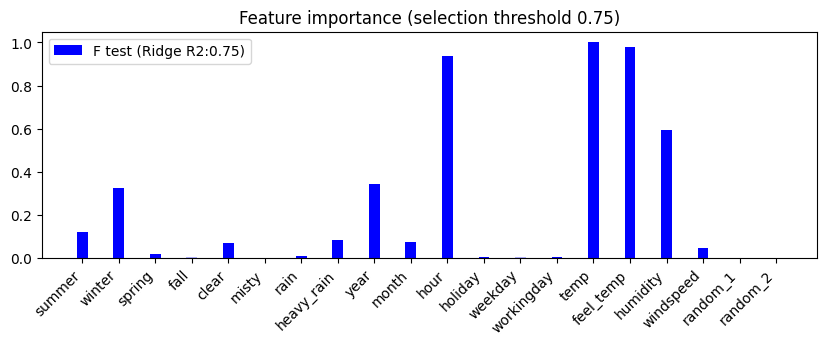

In [243]:
if not interactive:
    plot_feature_importances('FTest', None, threshold=0.75)

#### F-statistic

* For regression: does feature $X_i$ correlate (positively or negatively) with the target $y$?
$$\text{F-statistic} = \frac{\rho(X_i,y)^2}{1-\rho(X_i,y)^2} \cdot (N-1)$$
* For classification: uses ANOVA: does $X_i$ explain the within-class variance?
    * Alternatively, use the $\chi^2$ test (only for categorical features)
$$\text{F-statistic} = \frac{\text{within-class variance}}{\text{between-class variance}} =\frac{var(\overline{X_i})}{\overline{var(X_i)}}$$
<img src="../images/03_fstatistic2.png" alt="ml" style="width: 400px;"/>

### Mutual information
* Measures how much information $X_i$ gives about the target $Y$. In terms of entropy $H$:
$$MI(X,Y) = H(X) + H(Y) - H(X,Y)$$
* Idea: estimate H(X) as the average distance between a data point and its $k$ Nearest Neighbors
    * You need to choose $k$ and say which features are categorical
* Captures complex dependencies (e.g. hour, month), but requires more samples to be accurate

In [244]:
plot_feature_importances('MutualInformation', 'FTest', threshold=0.75)

### Model-based Feature Selection
* Use a [tuned](https://explained.ai/rf-importance/index.html)(!) supervised model to judge the importance of each feature
    * Linear models (Ridge, Lasso, LinearSVM,...): features with highest weights (coefficients)
    * Tree–based models: features used in first nodes (high information gain)
* Selection model can be different from the one you use for final modelling
* Captures interactions: features are more/less informative in combination (e.g. winter, temp)
* RandomForests: learns complex interactions (e.g. hour), but biased towards high cardinality features

In [245]:
plot_feature_importances('RandomForest', 'Lasso', threshold=0.75)

### Relief: Model-based selection with kNN

* For I iterations, choose a random point $\mathbf{x_i}$ and find $k$ nearest neighbors $\mathbf{x_{k}}$
* Increase feature weights if $\mathbf{x_i}$ and $\mathbf{x_{k}}$ have different class (near miss), else decrease
    * $\mathbf{w_i} = \mathbf{w_{i-1}} + (\mathbf{x_i} - \text{nearMiss}_i)^2 - (\mathbf{x_i} - \text{nearHit}_i)^2$
* Many variants: ReliefF (uses L1 norm, faster), RReliefF (for regression), ...

<img src="../images/relief.png" alt="ml" style="width: 400px;"/>

### Model-based Feature Selection (iterative)

* Dropping many features at once is not ideal: feature importance may change in subset
* Recursive Feature Elimination (RFE)
    * Remove $s$ least important feature(s), recompute remaining importances, repeat
* Selection model (e.g. RandomForest, Lasso) can be different from final model
* Can be rather slow

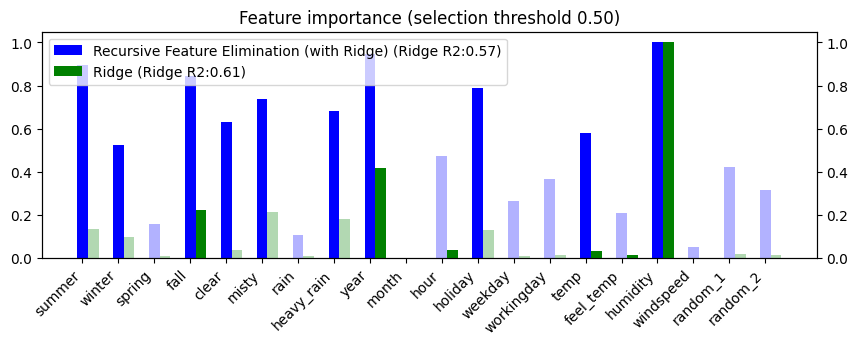

In [246]:
plot_feature_importances('RFE', 'Ridge', threshold=0.5)

### Sequential feature selection (Wrapping)

* Evaluate your model with different sets of features, find best subset based on performance
* Greedy search (can end up in local minima)
    * Backward selection: remove least important feature, recompute importances, repeat
    * Forward selection: set aside most important feature, recompute importances, repeat
    * Floating selection: add best new feature, remove worst one, repeat (forward or backward)
* Stochastic search: use random mutations in candidate subset (e.g. simulated annealing)

In [247]:
plot_feature_importances('ForwardSelection', 'Ridge', threshold=0.5)

### Permutation feature importance

* Defined as the decrease in model performance when a single feature value is randomly shuffled
    * This breaks the relationship between the feature and the target
* Model agnostic, metric agnostic, and can be calculated many times with different permutations
* Can be applied to unseen data (not possible with model-based techniques)
* Less biased towards high-cardinality features (compared with RandomForests)

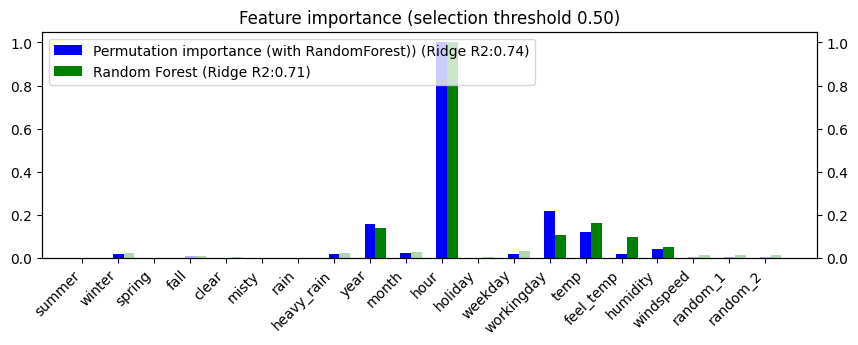

In [248]:
plot_feature_importances('Permutation', 'RandomForest', threshold=0.5)

### Comparison
* Feature importances (scaled) and cross-validated $R^2$ score of pipeline
    * Pipeline contains features selection + Ridge
* Selection threshold value ranges from 25% to 100% 0f all features
* Best method ultimately depends on the problem and dataset at hand

In [249]:
@interact
def compare_feature_importances(method1=methods, method2=methods, threshold=(0.25,1,0.25)):
    plot_feature_importances(method1,method2,threshold)

interactive(children=(Dropdown(description='method1', options=('FTest', 'MutualInformation', 'RandomForest', '…

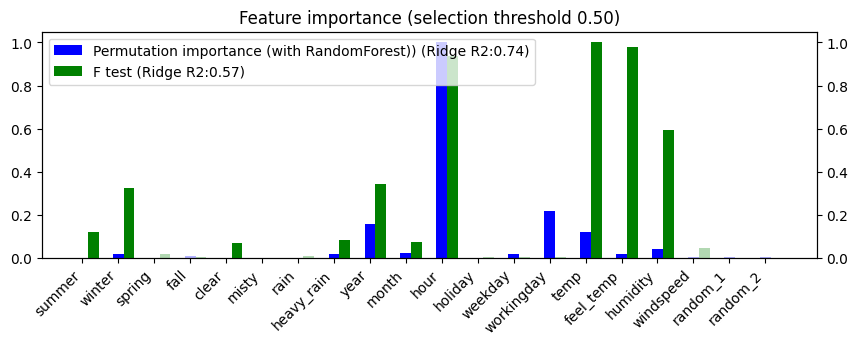

In [250]:
if not interactive:
    plot_feature_importances('Permutation', 'FTest', threshold=0.5)

#### In practice (scikit-learn)
* Unsupervised: `VarianceTreshold`

``` python
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
variances = selector.variances_
```

* Univariate:
    * For regression: `f_regression`, `mutual_info_regression`
    * For classification: `f_classification`, `chi2`, `mutual_info_classication`
    * Selecting: `SelectKBest`, `SelectPercentile`, `SelectFpr`,...
    
``` python
selector = SelectPercentile(score_func=f_regression, percentile=50)
X_selected = selector.fit_transform(X,y)
selected_features = selector.get_support()
f_values, p_values = f_regression(X,y)
mi_values = mutual_info_regression(X,y,discrete_features=[])
``` 

#### In practice (scikit-learn)
* Model-based:
    * `SelectFromModel`: requires a model and a selection threshold
    * `RFE`, `RFECV` (recursive feature elimination): requires model and final nr features

``` python
selector = SelectFromModel(RandomForestRegressor(), threshold='mean')
rfe_selector = RFE(RidgeCV(), n_features_to_select=20)
X_selected = selector.fit_transform(X)
rf_importances = Randomforest().fit(X, y).feature_importances_
```

* Sequential feature selection (from `mlxtend`, sklearn-compatible)

``` python
selector = SequentialFeatureSelector(RidgeCV(), k_features=20, forward=True, floating=True)
X_selected = selector.fit_transform(X)
```

* Permutation Importance (in `sklearn.inspection`), no fit-transform interface

``` python
importances = permutation_importance(RandomForestRegressor().fit(X,y), 
                                     X, y, n_repeats=10).importances_mean
feature_ids = (-importances).argsort()[:n]
```

## Feature Engineering
* Create new features based on existing ones
    * Polynomial features
    * Interaction features
    * Binning
* Mainly useful for simple models (e.g. linear models)
    * Other models can learn interations themselves
    * But may be slower, less robust than linear models

### Polynomials
* Add all polynomials up to degree $d$ and all products
    * Equivalent to polynomial basis expansions
$$[1, x_1, ..., x_p] \xrightarrow{} [1, x_1, ..., x_p, x_1^2, ..., x_p^2, ..., x_p^d, x_1 x_2, ..., x_{p-1} x_p]$$


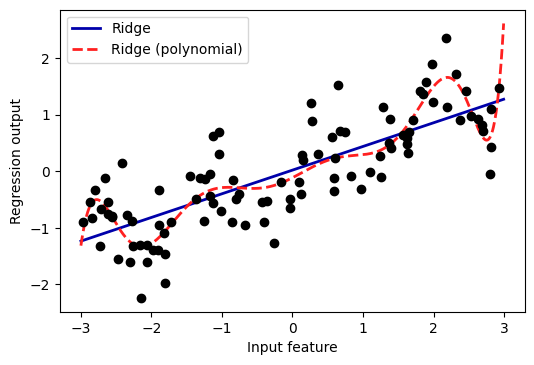

In [251]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

# Wavy data
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

# Normal ridge
lreg = Ridge().fit(X, y)
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")

# include polynomials up to x ** 10
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X)
preg = Ridge().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, preg.predict(line_poly), lw=2, label='Ridge (polynomial)')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Binning
- Partition numeric feature values into $n$ intervals (bins)
- Create $n$ new one-hot features, 1 if original value falls in corresponding bin
- Models different intervals differently (e.g. different age groups)

In [252]:
from sklearn.preprocessing import OneHotEncoder

# create 11 equal bins
bins = np.linspace(-3, 3, 5)
# assign to bins
which_bin = np.digitize(X, bins=bins)
# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
# Plot transformed data
bin_names = [('[%.1f,%.1f]') % i for i in zip(bins, bins[1:])]
df_orig = pd.DataFrame(X, columns=["orig"])
df_nr = pd.DataFrame(which_bin, columns=["which_bin"])
# add the original features
X_combined = np.hstack([X, X_binned])
ohedf = pd.DataFrame(X_combined, columns=["orig"]+bin_names).head(3)
ohedf.style.set_table_styles(dfstyle)

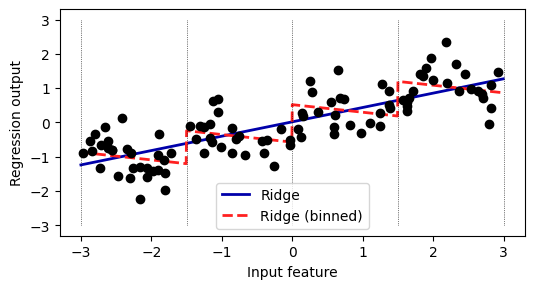

In [253]:
line_binned = encoder.transform(np.digitize(line, bins=bins))
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])

plt.rcParams['figure.figsize'] = [6, 3]
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")
plt.plot(line, reg.predict(line_combined), lw=2, label='Ridge (binned)')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k');

### Binning + interaction features
* Add _interaction features_ (or _product features_)
    * Product of the bin encoding and the original feature value
    * Learn different weights per bin

In [254]:
X_product = np.hstack([X_binned, X * X_binned])
bin_sname = ["b" + str(s) for s in range(4)] 
X_combined = np.hstack([X, X_product])
pd.set_option('display.max_columns', 10)
bindf = pd.DataFrame(X_combined, columns=["orig"]+bin_sname+["X*" + s for s in bin_sname]).head(3)
bindf.style.set_table_styles(dfstyle)

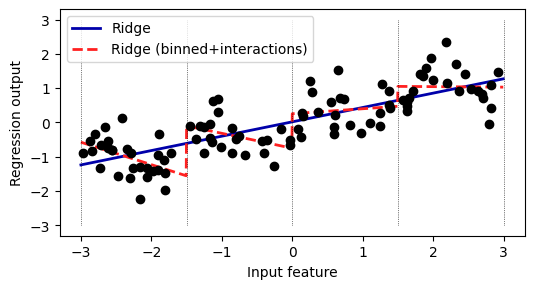

In [255]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")
plt.plot(line, reg.predict(line_product), lw=2, label='Ridge (binned+interactions)')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Categorical feature interactions
* One-hot-encode categorical feature
* Multiply every one-hot-encoded column with every numeric feature
* Allows to built different submodels for different categories

In [260]:
df = pd.DataFrame({'gender': ['M', 'F', 'M', 'F', 'F'],
                   'age': [14, 16, 12, 25, 22],
                   'pageviews': [70, 12, 42, 64, 93],
                   'time': [269, 1522, 235, 63, 21]
                  })
df.head(3)
df.style.set_table_styles(dfstyle)

In [261]:
dummies = pd.get_dummies(df)
df_f = dummies.multiply(dummies.gender_F, axis='rows')
df_f = df_f.rename(columns=lambda x: x + "_F")
df_m = dummies.multiply(dummies.gender_M, axis='rows')
df_m = df_m.rename(columns=lambda x: x + "_M")
res = pd.concat([df_m, df_f], axis=1).drop(["gender_F_M", "gender_M_F"], axis=1)
res.head(3)
res.style.set_table_styles(dfstyle)

## Missing value imputation
* Data can be missing in different ways:
    * Missing Completely at Random (MCAR): purely random points are missing
    * Missing at Random (MAR): something affects missingness, but no relation with the value
        * E.g. faulty sensors, some people don't fill out forms correctly
    * Missing Not At Random (MNAR): systematic missingness tells us something about the value
        * Has to be modelled or resolved (e.g. sensor decay, sick people leaving study)
* Missingness can be encoded in different ways:'?', '-1', 'unknown', 'NA',...
* Also labels can be missing (remove example or use semi-supervised learning)

In [259]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from fancyimpute import SoftImpute, IterativeSVD, MatrixFactorization

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Colors
norm = plt.Normalize()
colors = plt.cm.jet(norm([0,1,2]))
colors

# Iris dataset with some added noise and missing values
def missing_iris():
    iris = fetch_openml("iris", version=1, return_X_y=True)
    X, y = iris
    
    # Make some noise
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, 150)
    for i in range(4):
        X[:, i] = X[:, i] + noise
    
    # Add missing data. Set smallest leaf measurements to NaN
    rng = np.random.RandomState(0)
    mask = np.abs(X[:, 2] - rng.normal(loc=3.5, scale=.9, size=X.shape[0])) < 0.6
    X[mask, 2] = np.NaN
    mask2 = np.abs(X[:, 3] - rng.normal(loc=7.5, scale=.9, size=X.shape[0])) > 6.5
    X[mask2, 3] = np.NaN
    
    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)
    return X, y

# List of my favorite imputers
imputers = {"Mean Imputation": SimpleImputer(strategy="mean"), 
            "kNN Imputation": KNNImputer(), 
            "Iterative Imputation (RandomForest)": IterativeImputer(RandomForestRegressor()),
            "Iterative Imputation (BayesianRidge)": IterativeImputer(BayesianRidge()),
            "SoftImpute": SoftImpute(verbose=0),
            "Matrix Factorization": MatrixFactorization(verbose=0)
           }

@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UserWarning)
def plot_imputation(imputer=imputers.keys()):
    X, y = missing_iris()
    imputed_mask = np.any(np.isnan(X), axis=1)
    
    X_imp = None
    scores = None
    imp = imputers[imputer]
    if isinstance(imp, SimpleImputer) or isinstance(imp, KNNImputer) or isinstance(imp, IterativeImputer):
        X_imp = imp.fit_transform(X)
        imp_pipe = make_pipeline(SimpleImputer(), imp, LogisticRegression())
        scores = cross_val_score(imp_pipe, X_imp, y)
    else:
        X_imp = imp.fit_transform(X)
        scores = cross_val_score(LogisticRegression(), X_imp, y)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.set_title("{} (ACC:{:.3f})".format(imputer, np.mean(scores)))
    ax.scatter(X_imp[imputed_mask, 2], X_imp[imputed_mask, 3], c=y[imputed_mask], cmap='brg',alpha=.6, marker="s", edgecolors='b')
    ax.scatter(X_imp[~imputed_mask, 2], X_imp[~imputed_mask, 3], c=y[~imputed_mask], cmap='brg', alpha=.6)
    # this is for creating the legend...
    square = plt.Line2D((0,), (0,), linestyle='', marker="s", markerfacecolor="w", markeredgecolor="k", label='Imputed data')
    circle = plt.Line2D((0,), (0,), linestyle='', marker="o", markerfacecolor="w", markeredgecolor="k", label='Real data')
    plt.legend(handles=[square, circle], numpoints=1, loc="best")

### Mean imputation
* Replace all missing values of a feature by the same value
    * Numerical features: mean or median
    * Categorical features: most frequent category
    * Constant value, e.g. 0 or 'missing' for text features
* Example: Iris dataset
    * Randomly removed values in 3rd and 4th column

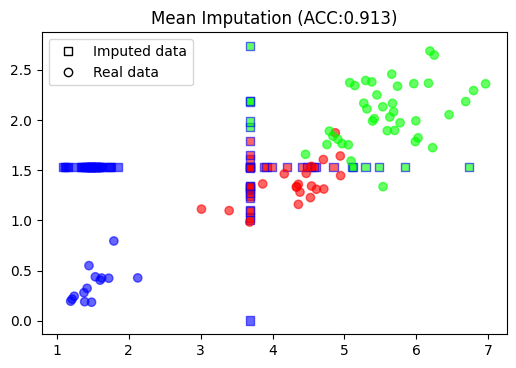

In [45]:
plot_imputation("Mean Imputation")

### kNN imputation
* Use special version of kNN to predict value of missing points
* Uses only non-missing data when computing distances

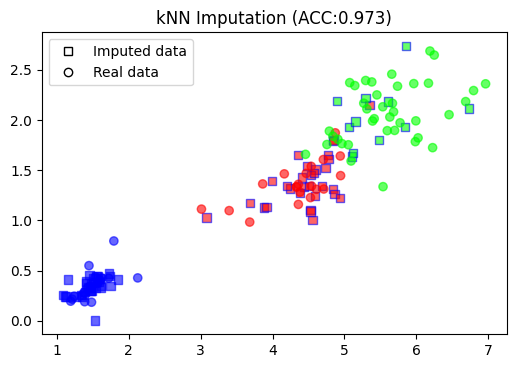

In [46]:
plot_imputation("kNN Imputation")

### Iterative (model-based) Imputation
* Better known as Multiple Imputation by Chained Equations (MICE)
* Iterative approach
    * Do first imputation (e.g. mean imputation)
    * Train model (e.g. RandomForest) to predict missing values of a given feature
    * Train new model on imputed data to predict missing values of the next feature  
        * Repeat $m$ times in round-robin fashion

In [47]:
plot_imputation("Iterative Imputation (RandomForest)")

### Soft-thresholded Singular Value Decomposition (SVD)
* Basic idea: low-rank approximation
    * Replace missing values by 0, compute SVD: $\mathbf{X}=\mathbf{U} \mathbf{\Sigma} \mathbf{V^{T}}$
    * Reduce eigenvalues by shrinkage factor: $\lambda_i = s\cdot\lambda_i$
    * Recompute $\mathbf{X}$: now complete
    * Repeat for $m$ iterations

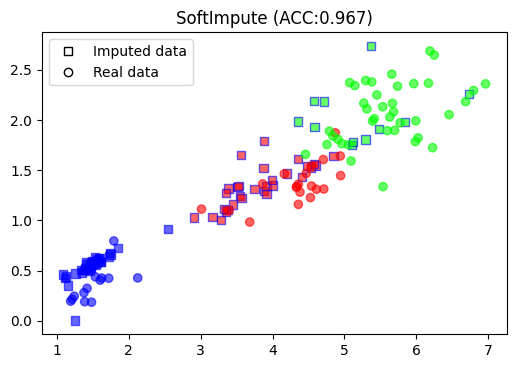

In [48]:
plot_imputation("SoftImpute")

### Matrix Factorization
* Same basic idea: low-rank approximation
    * Replace missing values by 0
    * Factorize $\mathbf{X}$ with rank $r$: $\mathbf{}X=\mathbf{U}^{p\times r} \mathbf{V}^{r\times n}$
        * With n data points and p features
    * Recompute $\mathbf{X}$: now complete


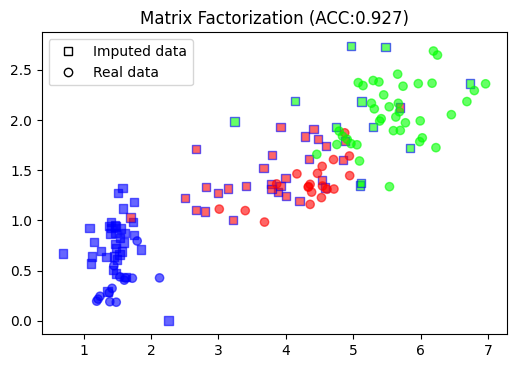

In [49]:
plot_imputation("Matrix Factorization")

### Comparison
* Best method depends on the problem and dataset at hand. Use cross-validation.
* Iterative Imputation (MICE) generally works well for missing (completely) at random data
    * Can be slow if the prediction model is slow
* Low-rank approximation techniques scale well to large datasets

In [50]:
@interact
def compare_imputers(imputer=imputers.keys()):
    plot_imputation(imputer=imputer)

interactive(children=(Dropdown(description='imputer', options=('Mean Imputation', 'kNN Imputation', 'Iterative…

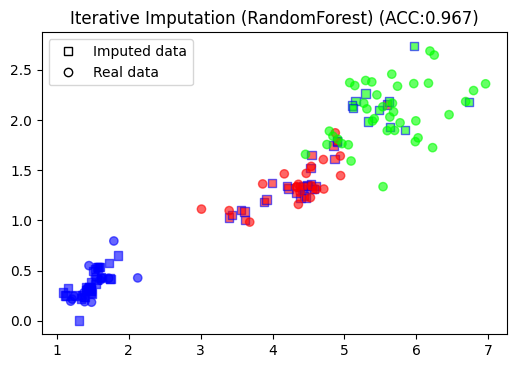

In [262]:
if not interactive:
    plot_imputation("Iterative Imputation (RandomForest)")

### In practice (scikit-learn)
* Simple replacement: `SimpleImputer`
    * Strategies: `mean` (numeric), `median`, `most_frequent` (categorical)
    * Choose whether to add indicator columns, and how missing values are encoded

``` python
imp = SimpleImputer(strategy='mean', missing_values=np.nan, add_indicator=False)
X_complete = imp.fit_transform(X_train)
```

* kNN Imputation: `KNNImputer`

``` python
imp = KNNImputer(n_neighbors=5)
X_complete = imp.fit_transform(X_train)
```

* Multiple Imputation (MICE): `IterativeImputer`
    * Choose estimator (default: `BayesianRidge`) and number of iterations (default 10)

``` python
imp = IterativeImputer(estimator=RandomForestClassifier(), max_iter=10)
X_complete = imp.fit_transform(X_train)
```

### In practice (fancyimpute)
* Cannot be used in CV pipelines (has `fit_transform` but no `transform`)
* Soft-Thresholded SVD: `SoftImpute`
    * Choose max number of gradient descent iterations 
    * Choose shrinkage value for eigenvectors (default: $\frac{1}{N}$)
 
``` python
imp = SoftImpute(max_iter=10, shrinkage_value=None)
X_complete = imp.fit_transform(X)
```

* Low-rank imputation: `MatrixFactorization`
    * Choose rank of the low-rank approximation
    * Gradient descent hyperparameters: learning rate, epochs,...
    * Several variants exist

``` python
imp = MatrixFactorization(rank=10, learning_rate=0.001, epochs=10000)
X_complete = imp.fit_transform(X)
```

## Handling imbalanced data
* Problem: 
    * You have a majority class with many times the number of examples as the minority class
    * Or: classes are balanced, but associated costs are not (e.g. FN are worse than FP)
* We already covered some ways to resolve this:
    * Add class weights to the loss function: give the minority class more weight
        * In practice: set `class_weight='balanced'`
    * Change the prediction threshold to minimize false negatives or false positives
* There are also things we can do by preprocessing the data
    * Resample the data to correct the imbalance
        * Random or model-based
    * Generate synthetic samples for the minority class 
    * Build ensembles over different resampled datasets
    * Combinations of these

In [88]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, CondensedNearestNeighbour
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline as make_imb_pipeline # avoid confusion
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

# Some imbalanced data
rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [1, 1]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)
X0min, X0max, X1min, X1max = np.min(X_syn[:,0]), np.max(X_syn[:,0]), np.min(X_syn[:,1]), np.max(X_syn[:,1])

samplers = [RandomUnderSampler(),EditedNearestNeighbours(),CondensedNearestNeighbour(),RandomOverSampler(),
           SMOTE(), ADASYN(), EasyEnsembleClassifier(), BalancedBaggingClassifier(), SMOTEENN()]
learners = [LogisticRegression(), SVC(), RandomForestClassifier()]

def plot_imbalance(sampler=RandomUnderSampler(), sampler2=None, learner=LogisticRegression()):
    
    # Appends multiple undersamplings for plotting purposes
    def simulate_bagging(sampler,X_syn, y_syn):
        X_resampled, y_resampled = sampler.fit_sample(X_syn, y_syn) 
        for i in range(10):
            X_resampled_i, y_resampled_i = sampler.fit_sample(X_syn, y_syn)
            X_resampled = np.append(X_resampled,X_resampled_i, axis=0)
            y_resampled = np.append(y_resampled,y_resampled_i, axis=0)
        return X_resampled, y_resampled
    
    def build_evaluate(sampler):
        # Build new data
        X_resampled, y_resampled = X_syn, y_syn
        if isinstance(sampler,EasyEnsembleClassifier):
            X_resampled, y_resampled = simulate_bagging(RandomUnderSampler(),X_syn, y_syn)
        elif isinstance(sampler,BalancedBaggingClassifier):
            balancer = RandomUnderSampler(sampling_strategy='all', replacement=True)
            X_resampled, y_resampled = simulate_bagging(balancer,X_syn, y_syn)
        else:
            X_resampled, y_resampled = sampler.fit_sample(X_syn, y_syn)

        # Evaluate
        if isinstance(sampler,EasyEnsembleClassifier):
            pipe = EasyEnsembleClassifier(base_estimator=learner)
        elif isinstance(sampler,BalancedBaggingClassifier):
            pipe = BalancedBaggingClassifier(base_estimator=learner)
        else:
            pipe = make_imb_pipeline(sampler, learner)
        scores = cross_validate(pipe, X_resampled, y_resampled, scoring='roc_auc')['test_score']
        return X_resampled, y_resampled, scores
    
    orig_scores = cross_validate(LogisticRegression(), X_syn, y_syn, scoring='roc_auc')['test_score']
        
    # Plot
    nr_plots = 2 if sampler2 is None else 3
    fig, axes = plt.subplots(1, nr_plots, figsize=(nr_plots*4, 4), subplot_kw={'xticks':(), 'yticks':()})
    axes[0].set_title("Original (AUC: {:.3f})".format(np.mean(orig_scores)))
    axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.tab10(y_syn), alpha=.3)
 
    X_resampled, y_resampled, scores = build_evaluate(sampler)
    axes[1].set_title("{} (AUC: {:.3f})".format(sampler.__class__.__name__, np.mean(scores)));
    axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.tab10(y_resampled), alpha=.3)
    plt.setp(axes[1], xlim=(X0min, X0max), ylim=(X1min, X1max))
    
    if sampler2 is not None:
        X_resampled, y_resampled, scores = build_evaluate(sampler2)
        axes[2].set_title("{} (AUC: {:.3f})".format(sampler2.__class__.__name__, np.mean(scores)));
        axes[2].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.tab10(y_resampled), alpha=.3)
        plt.setp(axes[2], xlim=(X0min, X0max), ylim=(X1min, X1max))
        
    plt.tight_layout()

### Random Undersampling
* Copy the points from the minority class
* Randomly sample from the majority class (with or without replacement) until balanced
    * Optionally, sample until a certain imbalance ratio (e.g. 1/5) is reached
    * Multi-class: repeat with every other class
* Preferred for large datasets, often yields smaller/faster models with similar performance

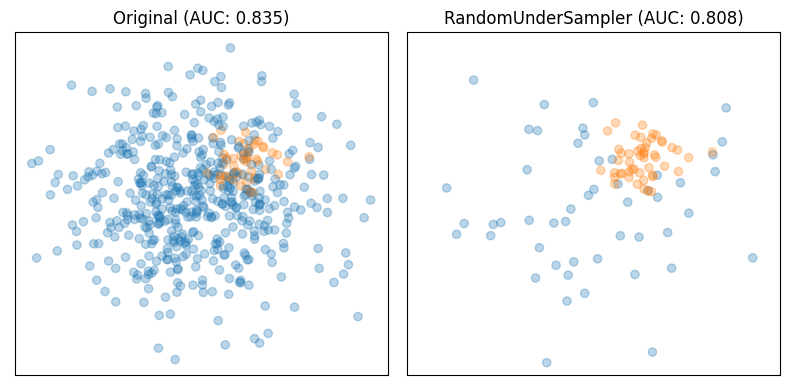

In [78]:
plot_imbalance(RandomUnderSampler())

### Model-based Undersampling
* Edited Nearest Neighbors
    * Remove all majority samples that are misclassified by kNN (mode) or that have a neighbor from the other class (all).
    * Remove their influence on the minority samples
* Condensed Nearest Neighbors
    * Remove all majority samples that are _not_ misclassified by kNN
    * Focus on only the hard samples

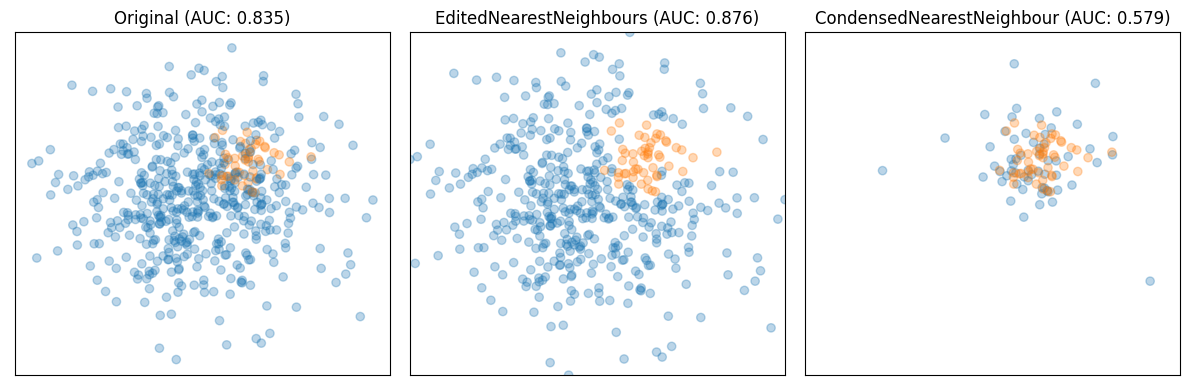

In [79]:
plot_imbalance(EditedNearestNeighbours(), CondensedNearestNeighbour())

### Random Oversampling
* Copy the points from the majority class
* Randomly sample from the minority class, with replacement, until balanced
    * Optionally, sample until a certain imbalance ratio (e.g. 1/5) is reached
* Makes models more expensive to train, doens't always improve performance
* Similar to giving minority class(es) a higher weight (and more expensive)

In [80]:
plot_imbalance(RandomOverSampler())

### Synthetic Minority Oversampling Technique (SMOTE)
* Repeatedly choose a random minority point and a neighboring minority point
    * Pick a new, artificial point on the line between them (uniformly)
* May bias the data. Be careful never to create artificial points in the test set.
* ADASYN (Adaptive Synthetic)
    * Similar, but starts from 'hard' minority points (misclassified by kNN)

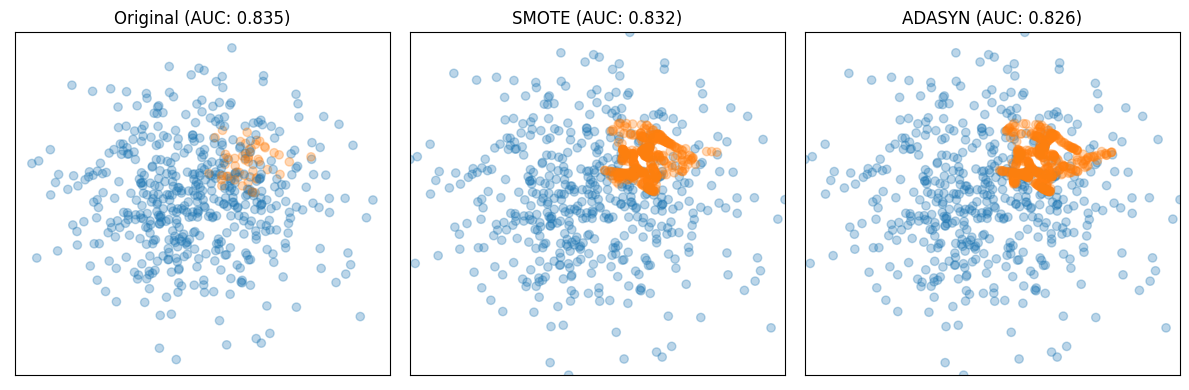

In [81]:
plot_imbalance(SMOTE(), ADASYN())

### Combined techniques
* Combines over- and under-sampling
* E.g. oversampling with SMOTE, undersampling with Edited Nearest Neighbors (ENN)
    * SMOTE can generate 'noisy' point, close to majority class points
    * ENN will remove up these majority points to 'clean up' the space

In [58]:
plot_imbalance(SMOTEENN())

### Ensemble Resampling
* Bagged ensemble of balanced base learners. Acts as a learner, not a preprocessor
    * Benefits of random undersampling without throwing out so much data
* BalancedBagging: take bootstraps, randomly undersample each, train models (e.g. trees)
* Easy Ensemble: take multiple random undersamplings directly, train models
    * Traditionally uses AdaBoost as base learner, but can be replaced

In [89]:
plot_imbalance(EasyEnsembleClassifier(), BalancedBaggingClassifier()) 

### Comparison
* The best method depends on the data (amount of data, imbalance,...)
    * For a very large dataset, random undersampling may be fine
* You still need to choose the appropriate learning algorithms
* Don't forget about class weighting and prediction thresholding
    * Some combinations makre useful, e.g. SMOTE + class weighting + thresholding

In [87]:
@interact
def compare_imbalance(sampler=samplers, learner=learners):
    plot_imbalance(sampler, None, learner)

interactive(children=(Dropdown(description='sampler', options=(RandomUnderSampler(), EditedNearestNeighbours()…

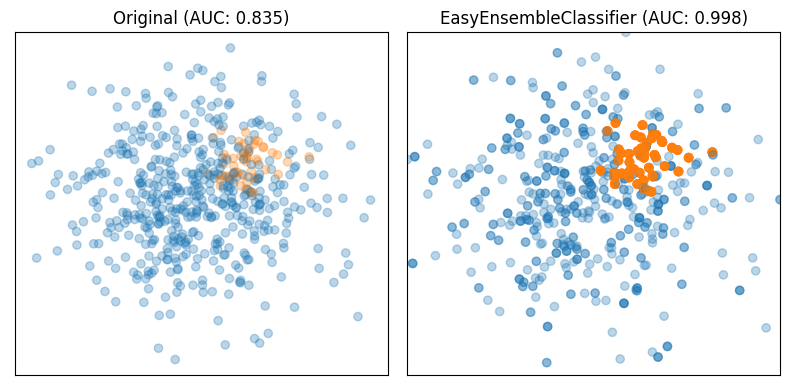

In [263]:
if not interactive:
    plot_imbalance(EasyEnsembleClassifier(), None, learner)

### In practice ([imblearn](http://imbalanced-learn.org))

* Follows fit-sample paradigm (equivalent of fit-transform, but also affects y)
* Undersampling: RandomUnderSampler, EditedNearestNeighbours, CondensedNearestNeighbour,...
* (Synthetic) Oversampling: RandomOverSampler, SMOTE, ADASYN,...
* Combinations: SMOTEENN,...
 
``` python
X_resampled, y_resampled = SMOTE(k_neighbors=5).fit_sample(X, y)
```

* Can be used in imblearn pipelines (not sklearn pipelines)
    * imblearn pipelines are compatible with GridSearchCV,...
    * Sampling is only done in `fit` (not in `predict`)

``` python
smote_pipe = make_pipeline(SMOTE(), LogisticRegression())
scores = cross_validate(smote_pipe, X_train, y_train)
param_grid = {"k_neighbors": [3,5,7]}
grid = GridSearchCV(smote_pipe, param_grid=param_grid, X, y)
```

* The ensembling techniques should be used as wrappers

``` python
clf = EasyEnsembleClassifier(base_estimator=SVC()).fit(X_train, y_train)
```

### Real-world data
* The effect of sampling procedures can be unpredictable
* Best method can depend on the data and FP/FN trade-offs
* SMOTE and ensembling techniques often work well

In [65]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Datasets
datasets = ['Speech','mc1','mammography']
    
roc_curves = {}

for dataset in datasets:
    print("Dataset", dataset)
    roc_curves[dataset] = {}
    
    # Get data
    data_imb = fetch_openml(dataset)
    X_imb, y_imb = data_imb.data, data_imb.target
    y_imb = LabelEncoder().fit_transform(y_imb)
    X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(X_imb, y_imb, stratify=y_imb, random_state=0)

    # Original data
    rf = RandomForestClassifier().fit(X_imb_train, y_imb_train)
    probs_original = rf.predict_proba(X_imb_test)[:, 1]
    fpr_org, tpr_org, _ = roc_curve(y_imb_test, probs_original)
    precision, recall, _ = precision_recall_curve(y_imb_test, probs_original)
    roc_curves[dataset]["original"] = {}
    roc_curves[dataset]["original"]["fpr"] = fpr_org
    roc_curves[dataset]["original"]["tpr"] = tpr_org
    roc_curves[dataset]["original"]["precision"] = precision
    roc_curves[dataset]["original"]["recall"] = recall

    # Corrected data
    for i, sampler in enumerate(samplers):
        sname = sampler.__class__.__name__
        print("Evaluating", sname)
        # Evaluate
        learner = RandomForestClassifier()
        if isinstance(sampler,EasyEnsembleClassifier):
            pipe = EasyEnsembleClassifier(base_estimator=learner)
        elif isinstance(sampler,BalancedBaggingClassifier):
            pipe = BalancedBaggingClassifier(base_estimator=learner)
        else:
            pipe = make_imb_pipeline(sampler, learner)

        pipe.fit(X_imb_train, y_imb_train)
        probs = pipe.predict_proba(X_imb_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_imb_test, probs)
        precision, recall, _ = precision_recall_curve(y_imb_test, probs)
        roc_curves[dataset][sname] = {}
        roc_curves[dataset][sname]["id"] = i
        roc_curves[dataset][sname]["fpr"] = fpr
        roc_curves[dataset][sname]["tpr"] = tpr
        roc_curves[dataset][sname]["precision"] = precision
        roc_curves[dataset][sname]["recall"] = recall

Dataset Speech
Evaluating RandomUnderSampler
Evaluating EditedNearestNeighbours
Evaluating CondensedNearestNeighbour
Evaluating RandomOverSampler
Evaluating SMOTE
Evaluating ADASYN
Evaluating EasyEnsembleClassifier
Evaluating BalancedBaggingClassifier
Evaluating SMOTEENN
Dataset mc1
Evaluating RandomUnderSampler
Evaluating EditedNearestNeighbours
Evaluating CondensedNearestNeighbour
Evaluating RandomOverSampler
Evaluating SMOTE
Evaluating ADASYN
Evaluating EasyEnsembleClassifier
Evaluating BalancedBaggingClassifier
Evaluating SMOTEENN
Dataset mammography
Evaluating RandomUnderSampler
Evaluating EditedNearestNeighbours
Evaluating CondensedNearestNeighbour
Evaluating RandomOverSampler
Evaluating SMOTE
Evaluating ADASYN
Evaluating EasyEnsembleClassifier
Evaluating BalancedBaggingClassifier
Evaluating SMOTEENN


In [75]:
# Colors for 9 methods
cm = plt.get_cmap('hsv')
roccol = []
for i in range(1,10):
    roccol.append(cm(1.*i/9))
    
curves = ['ROC','Precision-Recall']

@interact
def roc_imbalance(dataset=datasets, curve=curves):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Add to plot
    curvy = roc_curves[dataset]["original"]
    if curve == 'ROC':
        ax.plot(curvy["fpr"], curvy["tpr"], label="Original", lw=2, linestyle='-', c='k', alpha=.7)
    else:
        ax.plot(curvy["recall"], curvy["precision"], label="Original", lw=2, linestyle='-', c='k', alpha=.7)
    
    for method in roc_curves[dataset].keys():
        if method != "original":
            curvy = roc_curves[dataset][method]
            if curve == 'ROC':
                ax.plot(curvy["fpr"], curvy["tpr"], label=method, lw=2, linestyle='-', c=roccol[curvy["id"]-1], alpha=.7)
            else:
                ax.plot(curvy["recall"], curvy["precision"], label=method, lw=2, linestyle='-', c=roccol[curvy["id"]-1], alpha=.7)
        
    if curve == 'ROC':
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title("RandomForest ROC curve on {} dataset".format(dataset))
        ax.legend(ncol=2, loc="lower right")
    else:
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("RandomForest PR curve on {} dataset".format(dataset))
        ax.legend(ncol=2, loc="lower left")
    plt.tight_layout()

interactive(children=(Dropdown(description='dataset', options=('Speech', 'mc1', 'mammography'), value='Speech'…

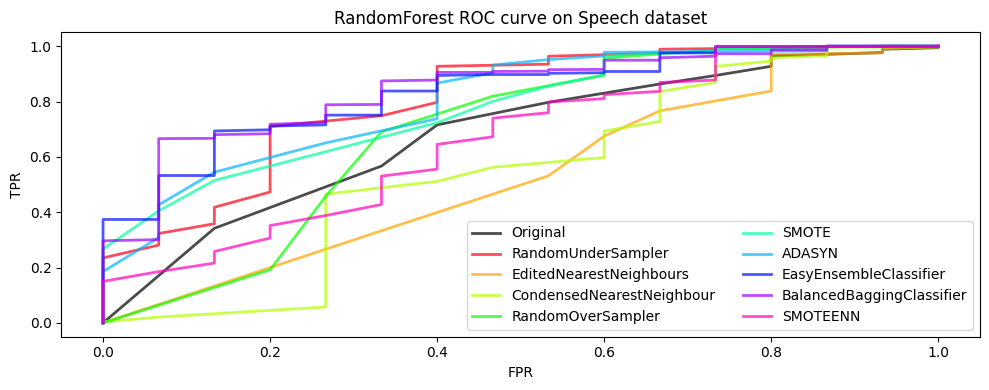

In [92]:
if not interactive:
    roc_imbalance(dataset='Speech', curve='ROC')

## Summary

* Data preprocessing is a crucial part of machine learning
    * Scaling is important for many distance-based methods (e.g. kNN, SVM, Neural Nets)
    * Categorical encoding is necessary for numeric methods (or implementations)
    * Selecting features can speed up models and reduce overfitting
    * Feature engineering is often useful for linear models
    * It is often better to impute missing data than to remove data
    * Imbalanced datasets require extra care to build useful models   
* Pipelines allow us to encapsulate multiple steps in a convenient way
    * Avoids data leakage, crucial for proper evaluation
* Choose the right preprocessing steps and models in your pipeline
    * Cross-validation helps, but the search space is huge
    * Smarter techniques exist to automate this process (AutoML)